<a href="https://colab.research.google.com/github/OkoksNeDam/geoinformation-data-forecasting/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting data from magnetometer stations with Prophet library.

## Data download.

In [ ]:
!pip install -r /content/requirements/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp310-cp310-linux_x86_64.whl size=209053 sha256=f32bb68df98750a08f359a612e3c84bbc0f49d3ef6e7b563532d0ecd0c8b6820
  Stored in directory: /root/.cache/pip/wheels/0e/c3/3c/8a9f55c3de0b09faf919393d4c6f09b11b7421dcaa7243b820
Successfully built hampel


In [ ]:
import gdown
requirements_url = 'https://drive.google.com/drive/folders/1RlVel5j8hW9Gxnr0SNQZTMJVvpQbbRLv?usp=share_link'
# Main data.
data_url         = 'https://drive.google.com/drive/folders/1Pf0soKlFy21_9VADQ4hvjbMeevTdjuOW?usp=sharing'

links = [requirements_url, data_url]

# Downloading data.
for url in links:
    gdown.download_folder(url, quiet=True)

## Import necessary libraries and set up the environment.

In [ ]:
import prophet
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.offline as py
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

from sklearn.impute import KNNImputer

Disable logger outputs from Prophet and cmdstanpy:

In [ ]:
import logging

logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

logging.getLogger('prophet').setLevel(logging.WARNING)

## Data processing and review.

In [69]:
original_df = pd.read_csv("/content/data/main_data.text", sep='\s+', na_values=99999.9)[['YYYY', 'MM',	'DD', 'HH', 'MM.1', 'SS', 'KEV_X']]
original_df.rename(columns={"MM.1": "mm"}, inplace=True)
original_df.head()

,YYYY,MM,DD,HH,mm,SS,KEV_X
0,1983,1,4,1,0,0,NaN
1,1983,1,4,2,0,0,NaN
2,1983,1,4,3,0,0,NaN
3,1983,1,4,4,0,0,NaN
4,1983,1,4,5,0,0,NaN


Fill missing dates

In [70]:
original_df.insert(0, 'date', original_df.apply(lambda x: datetime.datetime(int(x.YYYY), int(x.MM), int(x.DD), int(x.HH), int(x.mm), int(x.SS)), axis=1))
original_df.drop(columns=['YYYY',	'MM',	'DD',	'HH',	'mm',	'SS'], inplace=True)
original_df.set_index('date', inplace=True)
original_df = original_df.asfreq('H').reset_index()

In [71]:
original_df[original_df.KEV_X.notnull()].head()

,date,KEV_X
3969,1983-06-18 10:00:00,11280.3
3970,1983-06-18 11:00:00,11379.3
3971,1983-06-18 12:00:00,11442.1
3972,1983-06-18 13:00:00,11454.0
3973,1983-06-18 14:00:00,11369.1


Convert data to a format necessary for the Prophet library:

In [72]:
df = original_df.rename(columns={'date': 'ds',
                                'KEV_X': 'y'})
df.ds = pd.to_datetime(df.ds, format='%Y-%m-%d %H:%M:%S')
df.head()

,ds,y
0,1983-01-04 01:00:00,NaN
1,1983-01-04 02:00:00,NaN
2,1983-01-04 03:00:00,NaN
3,1983-01-04 04:00:00,NaN
4,1983-01-04 05:00:00,NaN


Amount of data:

In [73]:
df.shape

(357359, 2)

What raw time series data looks like.

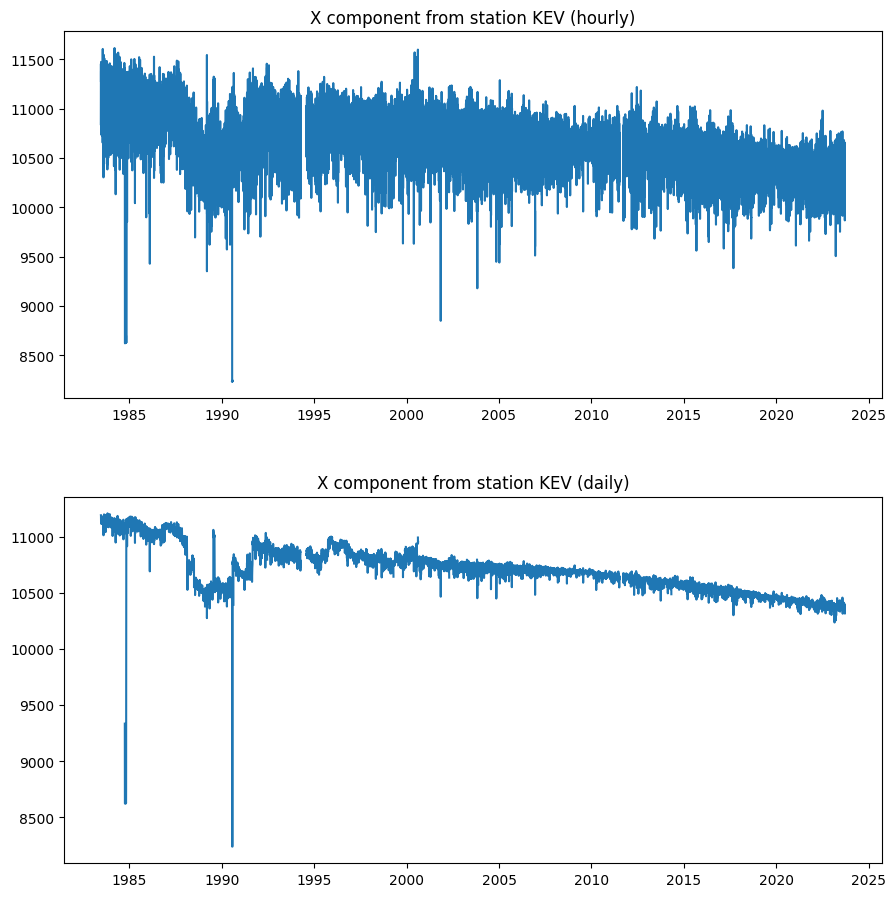

In [74]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
ax1.plot(df.ds, df.y)
ax1.set_title('X component from station KEV (hourly)')
ax2.plot(df.resample('1D', on='ds').mean().reset_index().ds, df.resample('1D', on='ds').mean().y)
ax2.set_title('X component from station KEV (daily)')
plt.show()

Data before 2003 is not of very good quality, so we will not use it:

In [75]:
df = df[df.ds > datetime.datetime.strptime('2003-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')].reset_index(drop=True)
df.head()

,ds,y
0,2003-01-01 01:00:00,10758.1
1,2003-01-01 02:00:00,10757.7
2,2003-01-01 03:00:00,10746.4
3,2003-01-01 04:00:00,10752.3
4,2003-01-01 05:00:00,10760.8


Train and test split:

In [163]:
train_size = int(df.shape[0] * 0.8)
test_size = df.shape[0] - train_size

df_train = df[:train_size].copy(deep=True)
df_val = df[train_size:int(train_size + test_size / 2)].copy(deep=True)
df_test = df[int(train_size + test_size / 2):].copy(deep=True)

df_train.shape, df_val.shape, df_test.shape

((145688, 2), (18211, 2), (18212, 2))

In [ ]:
def fill_missing_values(dataframe, method):
    dataframe = dataframe.copy(deep=True)
    if method == 'default':
        return dataframe
    # fill with mean.
    if method == 'mean':
        return dataframe.fillna(dataframe.mean(numeric_only=True).round(1))
    # fill with median.
    if method == 'median':
        return dataframe.fillna(dataframe.median(numeric_only=True).round(1))
    # fill with knn method.
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=15)
        dataframe = dataframe.apply(lambda col: imputer.fit_transform(col.to_numpy().reshape(-1, 1)).T[0] if col.name != "ds" else col)
        return dataframe

    return dataframe

Functions that can handle missing values to calculate metrics:

In [ ]:
def calc_mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.nanmean((y_true - y_pred) ** 2)

def calc_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

def calc_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.nanmean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) / 2)) * 100

Function that evaluates model and finds mse, mape and smape metrics:

In [ ]:
def evaluate_model(model, df_test):
    future = df_test[['ds']]
    forecast = model.predict(future)

    predictions = forecast.iloc[-len(df_test):]['yhat']
    actuals = df_test['y']

    mse = calc_mse(actuals, predictions)
    mape = calc_mape(actuals, predictions)
    smape = calc_smape(actuals, predictions)

    return mse, mape, smape, actuals, predictions

Find best method (by mse metric) for filling missing values:

In [ ]:
methods = ['default', 'mean', 'median', 'knn']
mses = {"mse":[]}

for method in tqdm(methods, position=0, leave=True):
    # Replace nan values.
    no_nan_df = fill_missing_values(df_train, method)
    no_nan_df.reset_index(inplace=True)
    model = Prophet()
    model.fit(no_nan_df)

    mse, _, _, _, _ = evaluate_model(model, df_val)
    mses['mse'] += [mse]

print(f"\nBest method: {methods[np.argmin(mses['mse'])]}")
fill_mv_results = pd.DataFrame(mses)
fill_mv_results.insert(0, 'methods', methods)
fill_mv_results.sort_values("mse").reset_index(drop=True)

100%|██████████| 4/4 [05:02<00:00, 75.61s/it]


Best method: default


,methods,mse
0,default,3418.323797
1,knn,3421.828935
2,mean,3427.187072
3,median,3439.820967


Normalizing data:

In [165]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train.y = scaler.fit_transform(np.array(df_train.y).reshape(-1, 1)).T[0]
df_val.y = scaler.transform(np.array(df_val.y).reshape(-1, 1)).T[0]
df_test.y = scaler.transform(np.array(df_test.y).reshape(-1, 1)).T[0]

Drop outliers:

In [169]:
from hampel import hampel

result = hampel(df_train.y, window_size=10000, n_sigma=3.0)
df_train_copy = df_train.copy(deep=True)
df_train_copy.y = result.filtered_data

KeyboardInterrupt: ignored

Visualize train and test data without outliers:

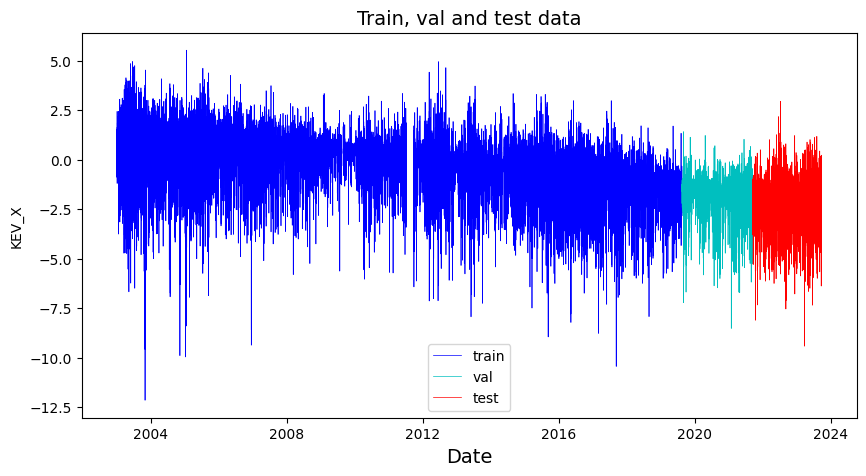

In [170]:
plt.figure(figsize=(10,5))

plt.plot(df_train.ds, df_train.y, color='b', label='train', linewidth=0.5)
plt.plot(df_val.ds, df_val.y, color='c', label='val', linewidth=0.5)
plt.plot(df_test.ds, df_test.y, color='r', label='test', linewidth=0.5)

plt.xlabel("Date", fontsize=14)
plt.ylabel("KEV_X")
plt.title("Train, val and test data", fontsize=14)

plt.legend()

plt.show()

## Model training.

In [ ]:
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_test.reset_index(inplace=True)

Let's look at baseline model performance:

In [ ]:
baseline_model = Prophet()
baseline_model.fit(df_train)

In [ ]:
mse, mape, smape, _, _ = evaluate_model(baseline_model, df_val)

print(f'mse: {mse}, mape: {mape}, smape: {smape}')
# mse: 0.27443216386854863, mape: 25.70532502628196, smape: 16.577266833557726

mse: 0.2803635319458515, mape: 23.622650399497562, smape: 16.895259936033018


Let's look at model performance by changing chengepoint_range. The best model was with the default changepoint_range parameter (=0.8)

In [ ]:
mses = []
crs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for cr in tqdm(crs, position=0, leave=True):
    baseline_model = Prophet(changepoint_range=cr)
    baseline_model.fit(df_train)

    baseline_model_cv = cross_validation(baseline_model, initial='1095 days', period='365 days', horizon='365 days', disable_tqdm=True)
    baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
    mses.append(baseline_model_p['mse'].values[0])


print(f"Best changepoint_range: {crs[np.argmin(mses)]}")
chose_changepoint_range_results = pd.DataFrame({"changepoint_ranges": crs})
chose_changepoint_range_results['mse'] = mses
chose_changepoint_range_results.sort_values("mse").reset_index(drop=True)

100%|██████████| 9/9 [02:28<00:00, 16.51s/it]

Best changepoint_range: 0.6


,changepoint_ranges,mse
0,0.6,384.049963
1,0.5,388.772870
2,0.7,395.525827
3,0.4,405.802943
4,0.9,412.975311
5,0.8,432.902800
6,0.3,456.522257
7,0.2,540.955674
8,0.1,671.646170


Get all combinations from additional regressors:

In [ ]:
variables_list = ['Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B']

list_combinations = []
for i in range(len(variables_list) + 1):
    list_combinations += list(itertools.combinations(variables_list, i))
list_combinations[-10:]

[('Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z'),
 ('Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'sigma_B'),
 ('Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'dBrms', 'Delta', 'Bn', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'dBrms', 'Delta', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'dBrms', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B'),
 ('Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B')]

Find best combination of additional regressors:

In [ ]:
%%time
mses = []
for combination in tqdm(list_combinations):
    m = Prophet(changepoint_range=0.9)
    for regressor in combination:
        m.add_regressor(regressor)
    m.fit(df_train)
    df_cv = cross_validation(m, horizon="365 days", period="365 days", initial="1095 days", disable_tqdm=True)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])

tuning_results = pd.DataFrame(list_combinations)
tuning_results['mse'] = mses
best_combination = list_combinations[np.argmin(mses)]
print(best_combination)
tuning_results.sort_values("mse").reset_index(drop=True).head(10)

  0%|          | 0/256 [00:03<?, ?it/s]


KeyboardInterrupt: ignored

Fit model with additional regressors:

In [ ]:
reg_model = Prophet(changepoint_range=0.9)
reg_model.add_regressor('Bmag')
reg_model.add_regressor('dBrms')
reg_model.add_regressor('Br')
reg_model.add_regressor('Lambda')
reg_model.add_regressor('Bgsm_z')

reg_model.fit(df_train)

reg_model_cv = cross_validation(reg_model, initial='1095 days', period='365 days', horizon='365 days', disable_tqdm=True)
performance_metrics(reg_model_cv, rolling_window=1)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,66.649017,8.163885,5.87304,0.000554,0.000445,0.000553,0.897847


Automatic hyperparameter tuning by MSE metric:

In [ ]:
%%time
# Set up parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.0015, 0.002, 0.0025],
    'seasonality_prior_scale': [8, 9, 10, 11, 12],
    'seasonality_mode': ['additive', 'multiplicative'],
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Create a list to store MAPE values for each combination
mses = []
# Use cross validation to evaluate all parameters
for params in tqdm(all_params, position=0, leave=True):
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.6)
    # m.add_regressor('Bmag')
    # m.add_regressor('dBrms')
    # m.add_regressor('Br')
    # m.add_regressor('Lambda')
    # m.add_regressor('Bgsm_z')
    m.fit(df_train)
    # Cross-validation
    df_cv = cross_validation(m, horizon="365 days", period="365 days", initial="1095 days", disable_tqdm=True)
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mses.append(df_p['smape'].values[0])

# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['smape'] = mses
# Find the best parameters
best_params = all_params[np.argmin(mses)]
print(best_params)
tuning_results.sort_values("smape").reset_index(drop=True)

100%|██████████| 40/40 [09:17<00:00, 13.94s/it]

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 11, 'seasonality_mode': 'additive'}
CPU times: user 4min 52s, sys: 1min 5s, total: 5min 57s
Wall time: 9min 17s


,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,smape
0,0.0010,11,additive,0.001178
1,0.0010,9,multiplicative,0.001178
2,0.0010,10,multiplicative,0.001178
3,0.0010,8,multiplicative,0.001178
4,0.0010,11,multiplicative,0.001179
5,0.0010,9,additive,0.001179
6,0.0020,11,additive,0.001179
7,0.0015,11,additive,0.001179
8,0.0015,11,multiplicative,0.001179
9,0.0020,10,multiplicative,0.001179


Fit model with tuned parameters:

In [ ]:
tuned_model = Prophet(changepoint_range=0.7, changepoint_prior_scale=0.005, seasonality_prior_scale=10, seasonality_mode='additive')
tuned_model.add_regressor('Bmag')
tuned_model.add_regressor('dBrms')
tuned_model.add_regressor('Br')
tuned_model.add_regressor('Lambda')
tuned_model.add_regressor('Bgsm_z')
tuned_model.fit(df_train)

tuned_model_cv = cross_validation(tuned_model, initial='1095 days', period='365 days', horizon='365 days', disable_tqdm=True)
performance_metrics(tuned_model_cv, rolling_window=1)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,72.361815,8.506575,5.962067,0.000563,0.000425,0.000563,0.83816


Get predictions of best model:

In [ ]:
future = df_test[['ds','Bmag',	'dBrms',	'Br',	'Lambda',	'Bgsm_z']]
forecast = tuned_model.predict(future)

predictions = forecast.iloc[-len(df_test):]['yhat']
actuals = df_test['y']
print(f"r2 score: {r2_score(predictions, actuals)}")
print(f"mse: {mean_squared_error(predictions, actuals)}")
print(f"mape: {mean_absolute_percentage_error(predictions, actuals)}")
print(f"smape: {smape(predictions, actuals)}")

r2 score: -0.02099432778619459
mse: 517.3442074637699
mape: 0.0015100921799885128
smape: 0.15115628870262052


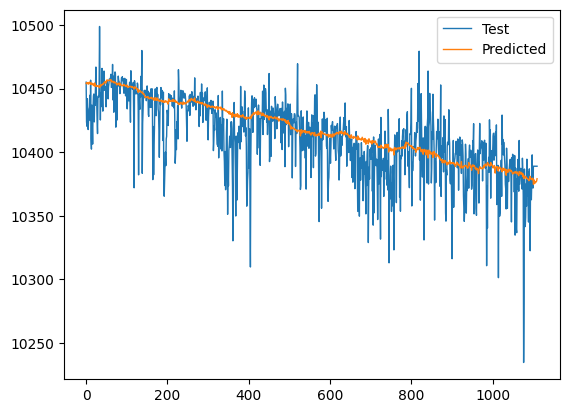

In [ ]:
plt.plot(actuals, label='Test', linewidth=1)
plt.plot(predictions, label='Predicted', linewidth=1)
plt.legend()
plt.show()

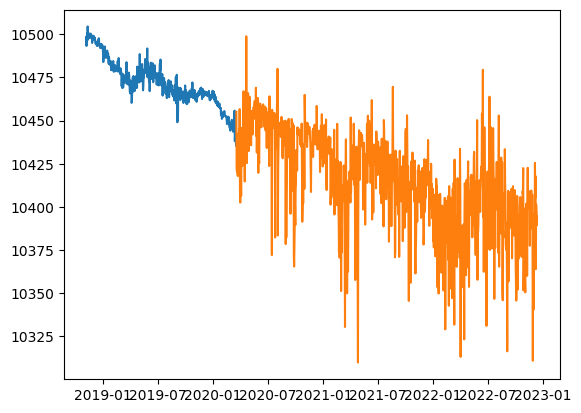

In [ ]:
plt.plot(df_train[-500:].ds, df_train[-500:].y)
plt.plot(df_test[:1000].ds, df_test[:1000].y)

In [ ]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(tuned_model))  # Save model